# LSTM Autoendcoder for Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

2024-04-04 18:55:06.014127: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 18:55:06.031887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('../Datasets/Car_Hacking_Challenge_Dataset/0_Preliminary/1_Submission/Pre_submit_D.csv')
#data = pd.read_csv('../Datasets/Car_Hacking_Challenge_Dataset/0_Preliminary/1_Submission/Pre_submit_S.csv')

## Data Preprocessing Function

In [3]:
def preprocessing(data):
    
    # get intervals from original dataframe
    df = pd.DataFrame()
    df['Intervals']=data['Timestamp'].diff()
    
    # add two columns 
    df[['Arbitration_ID', 'DLC']] = data[['Arbitration_ID', 'DLC']]
    df['Arbitration_ID'] = df['Arbitration_ID'].apply(int, base=16)
    
    # split Data column into eight colums and add them to a new dataframe
    col_list = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
    data_list = pd.DataFrame()
    data_list[col_list] = data['Data'].str.split(' ', expand=True)
    
    # fill NaNs with string 
    data_list.fillna('00', inplace=True)

    # convert hex-strings into integers 
    for d in col_list:
        data_list[d] = data_list[d].apply(int, base=16)

    # add data to intervals and fill NaNs with zerous
    df[col_list] = data_list
    df.fillna(0, inplace=True)

    # scale the data
    scaler = pp.MinMaxScaler()
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df)
    

    # get labels
    labels = pd.DataFrame()
    labels['Class'] = data['Class']

    # replace strings with numbers
    labels = labels.replace(to_replace='Normal', value=0)
    labels = labels.replace(to_replace='Attack', value=1)

    return df, labels

## 2.Train-Test-Validataion Split

In [4]:
d_train, d_val, = train_test_split(data, shuffle=False, test_size=0.1)
d_train, d_test, = train_test_split(data, shuffle=False, test_size=0.15)

In [5]:
# remove anomaliest from train data 
#d_train = d_train[d_train.Class != 'Attack']

In [6]:
X_train, y_train = preprocessing(d_train)
X_train.shape

(1700623, 11)

In [7]:
X_test, y_test = preprocessing(d_test)
y_test.shape

(300110, 1)

In [8]:
X_val, y_val = preprocessing(d_val)
y_val.shape

(200074, 1)

In [9]:
# anomaly counts
train_anomalies = y_train['Class'].sum()
print(f'Number anomalies in train data: {train_anomalies}')
test_anomalies = y_test['Class'].sum()
print(f'Number anomalies in test data: {test_anomalies}')
val_anomalies = y_val['Class'].sum()
print(f'Number anomalies in validation data: {val_anomalies}')

Number anomalies in train data: 178925
Number anomalies in test data: 22762
Number anomalies in validation data: 18239


## 3. Convert Data into Sequences

In [10]:
# convert function 
def to_sequences(data, n_steps):
    samples = list()
    for i in range(len(data)):
        # find the end 
        end_ix = i + n_steps
        # check if beyond the data
        if end_ix > len(data):
            break
        seq = data[i:end_ix]
        samples.append(seq)
    return np.array(samples)

In [11]:
n_steps = 2
X_train = to_sequences(X_train, n_steps)
y_train = to_sequences(y_train, n_steps)
print(X_train.shape)
print(y_train.shape)

(1700622, 2, 11)
(1700622, 2, 1)


In [12]:
X_test = to_sequences(X_test, n_steps)
y_test = to_sequences(y_test, n_steps)
print(X_test.shape)
print(y_test.shape)

(300109, 2, 11)
(300109, 2, 1)


In [13]:
X_val = to_sequences(X_val, n_steps)
y_val = to_sequences(y_val, n_steps)
print(X_val.shape)
print(y_val.shape)

(200073, 2, 11)
(200073, 2, 1)


In [14]:
# convert y-sequences into classes
y_train_class = y_train.sum(axis=1)
y_train_class = np.array([y==1 if y.sum()>0 else y==0 for y in y_train_class])
y_train_class.shape

(1700622, 1)

In [15]:
# convert y-sequences into classes
y_test_class = y_test.sum(axis=1)
y_test_class = np.array([y==1 if y.sum()>0 else y==0 for y in y_test_class])
y_test_class.shape

(300109, 1)

In [16]:
# convert y-sequences into classes
y_val_class = y_val.sum(axis=1)
y_val_class = np.array([y==1 if y.sum()>0 else y==0 for y in y_val_class])
y_val_class.shape

(200073, 1)

## 4.Define LSTM

In [17]:
# model parameters
n_features = X_train.shape[2]
n_hidden = 32

In [18]:
def lstm_model(n_steps, n_features, lr=0.011):
    # define layers
    inputs = tf.keras.Input(shape=(n_steps, n_features))
    lstm1 =  tf.keras.layers.LSTM(n_hidden, activation='tanh', dropout=0)
    vector = tf.keras.layers.RepeatVector(n_steps)
    lstm2 =  tf.keras.layers.LSTM(n_hidden, activation='tanh', dropout=0, return_sequences=True)
    dense =  tf.keras.layers.Dense(n_features)
    outputs = tf.keras.layers.TimeDistributed(dense)
    layers = [inputs, lstm1, vector, lstm2, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    rmse = tf.keras.metrics.RootMeanSquaredError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=[rmse, mae])
    return model

## 4.Train Model

In [19]:
model = lstm_model(n_steps, n_features, lr=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5632      
                                                                 
 repeat_vector (RepeatVecto  (None, 2, 32)             0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 2, 32)             8320      
                                                                 
 time_distributed (TimeDist  (None, 2, 11)             363       
 ributed)                                                        
                                                                 
Total params: 14315 (55.92 KB)
Trainable params: 14315 (55.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.001,
                                                  patience=10,
                                                  verbose=0,
                                                  mode='auto',
                                                  restore_best_weights=True)
history = model.fit(X_train,
                    X_train,
                    epochs=100,
                    batch_size=20000,
                    validation_data=(X_test, X_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
86/86 [==============================] - 3s 24ms/step - loss: 0.1099 - root_mean_squared_error: 0.3316 - mean_absolute_error: 0.2357 - val_loss: 0.0709 - val_root_mean_squared_error: 0.2663 - val_mean_absolute_error: 0.2080
Epoch 2/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0578 - root_mean_squared_error: 0.2403 - mean_absolute_error: 0.1822 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2292 - val_mean_absolute_error: 0.1710
Epoch 3/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0455 - root_mean_squared_error: 0.2133 - mean_absolute_error: 0.1554 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2061 - val_mean_absolute_error: 0.1516
Epoch 4/100
86/86 [==============================] - 2s 20ms/step - loss: 0.0368 - root_mean_squared_error: 0.1917 - mean_absolute_error: 0.1380 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1824 - val_mean_absolute_error: 0.1323
Epoch 5/100
86/86 [==============================] - 2s 

Minimal Loss: 0.0003


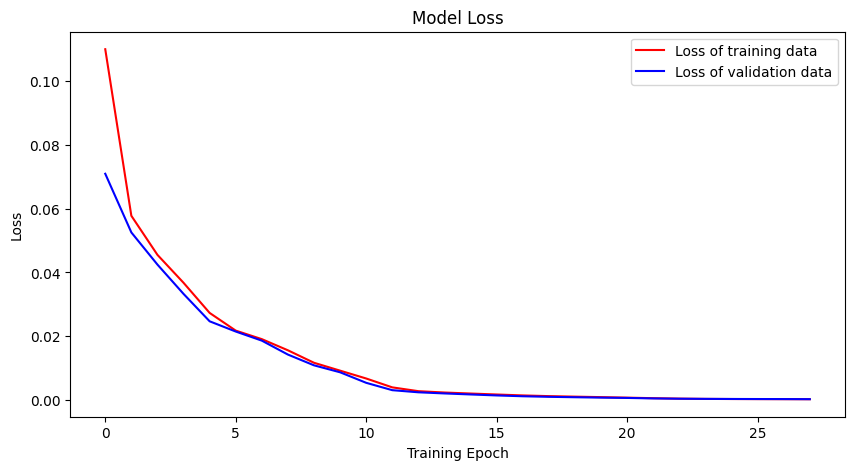

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_loss = min(val_loss)
print(f'Minimal Loss: {min_loss:.4f}')
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Loss of training data')
plt.plot(val_loss, 'b-', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

## 5. Evaluate Model

In [22]:
predictions = model.predict(X_val, verbose=1)

6253/6253 [==============================] - 7s 1ms/step


In [23]:
def reconstr_error(original, reconstr):
    errors = np.sqrt(np.sum((original - reconstr)**2, axis=1))
    return errors

In [24]:
errors = reconstr_error(X_val, predictions)

In [25]:
errors = errors.sum(axis=1)
errors = errors.reshape(-1, 1)

In [26]:
# average precision score test
aps_val = average_precision_score(y_val_class, errors)
print(f'Average precision score for validation: {aps_val:.4f}')

Average precision score for validation: 0.9494


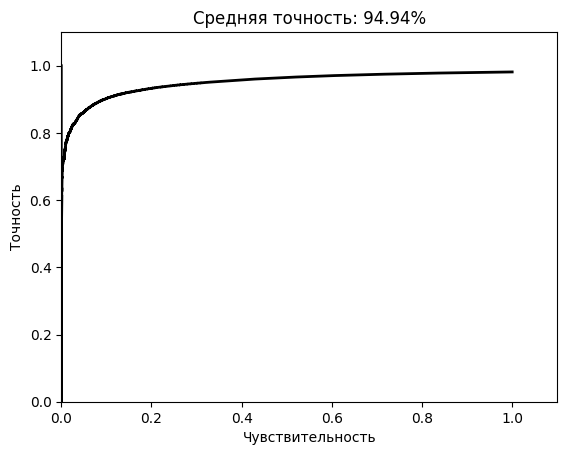

In [27]:
# precision-recall curve for test results
precision, recall, thresholds = precision_recall_curve(y_val_class, errors)
plt.title(f'Средняя точность: {aps_val*100:.2f}%')
plt.xlabel('Чувствительность')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Точность')
#plt.ylim([0, 1.1])
#plt.xlim([0, 1.0])
plt.plot(recall, precision, lw=2, color='k')
plt.savefig('Average_precision_D.png')
plt.show()

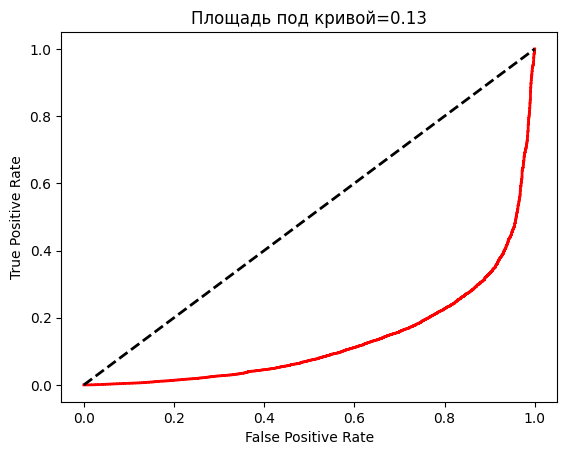

In [28]:
# receiver operational characteristic
fpr, tpr, thresholds = roc_curve(y_val_class, errors)
auROC = auc(fpr, tpr)
plt.figure()
plt.title(f'Площадь под кривой={auROC:.2f}')
plt.plot(fpr, tpr, color='r', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], color='k', lw=2, linestyle='--')
plt.show()